In [177]:
import numpy as np
from gym import envs
import gym
import random
import sys

import pickle
import pandas as pd 

In [178]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [179]:
def load( name):
    Q_vals = pd.read_pickle(name)
    return Q_vals

In [180]:
test_episodes=200

In [181]:
import collections
pickup_dropoff=[(0,0), (0,4), (4,0), (4,3)]


In [182]:
 def decode(i):
    out = []
    out.append(i % 4)
    i = i // 4
    out.append(i % 5)
    i = i // 5
    out.append(i % 5)
    i = i // 5
    out.append(i)
    assert 0 <= i < 5
    return reversed(out)
def encode( taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

def move_taxi(taxi_position,destination,move_pattern,destination_objective ):
    reward=0
    done = False
    if move_pattern=='top-bottom':
#         print(99)
        if taxi_position[0]> destination[0] :
#             print(112)
            if taxi_position[0]>2 and destination[0]>2 and ( (destination[1]==0 and taxi_position[1]>0)  or (destination[1]==3 and taxi_position[1]<3)):
                taxi_position[0]=taxi_position[0]+1
#                 print(11)
            elif taxi_position[0]<2 and destination[0]<2 and ( (destination[1]==0 and taxi_position[1]>1)  or (destination[1]==4 and taxi_position[1]<2)):
                taxi_position[0]=taxi_position[0]+1
            else: 
                taxi_position[0]=taxi_position[0]-1
            reward=-1
        elif taxi_position[0]< destination[0]:
#             print(1124)
            if taxi_position[0]>2 and destination[0]>2 and ( (destination[1]==0 and taxi_position[1]>0)  or (destination[1]==3 and taxi_position[1]<3)):
                taxi_position[0]=taxi_position[0]-1
#                 print(11)
            elif taxi_position[0]<2 and destination[0]<2 and ( (destination[1]==0 and taxi_position[1]>1)  or (destination[1]==4 and taxi_position[1]<2)):
                taxi_position[0]=taxi_position[0]-1
            else:
                taxi_position[0]=taxi_position[0]+1 
                
            reward=-1
        else:
#             print(1123)
            if taxi_position[0]>2 and destination[0]>2 and ( (destination[1]==0 and taxi_position[1]>0)  or (destination[1]==3 and taxi_position[1]<3)):
                taxi_position[0]=taxi_position[0]-1
                reward=-1
            elif taxi_position[0]<2 and destination[0]<2 and ( (destination[1]==0 and taxi_position[1]>1)  or (destination[1]==4 and taxi_position[1]<2)):
                taxi_position[0]=taxi_position[0]+1
                reward=-1

#         print(taxi_position[0])
        if (taxi_position[0]==2 or taxi_position[0]==0 or taxi_position[0]==4)  and taxi_position[1]!= destination[1]:
            move_pattern='left-right'
        

        
    else:
#         print(999)
        if taxi_position[1]> destination[1] :
            taxi_position[1]=taxi_position[1]-1
            reward=-1
        elif taxi_position[1]< destination[1]:  
            taxi_position[1]=taxi_position[1]+1
            reward=-1
        
        if taxi_position[1]== destination[1]:
            move_pattern='top-bottom'

    if collections.Counter(taxi_position) == collections.Counter(destination):
        if destination_objective=='pickup':
            destination_objective='dropoff'
            reward=-1 +reward
        else:
            reward=20+reward
            done=True
        

    
    return taxi_position,move_pattern,destination_objective,reward,done

def benchmark(state,print_for_debug=False):
    env_test = gym.make("Taxi-v3").env
    if print_for_debug:
        env_test.s = state
        env_test.render()
    
    done =False
    decode_state= list(env.decode (state) )
    org_decode_state= decode_state
    score=0
    if print_for_debug: print(pickup_dropoff[decode_state[2]])
    #print(pickup_dropoff[decode_state[3]])
    if print_for_debug: print(decode_state)
    taxi_position=list((decode_state[0],decode_state[1]))
    destination=list(pickup_dropoff[decode_state[2]])
    move_pattern='top-bottom'
    destination_objective='pickup'
#     print(taxi_position[0])
#     print(destination[0])
    if taxi_position[0]==destination[0]:
        move_pattern='left-right'
        if taxi_position[0]>2 and ((destination[1]==0 and taxi_position[1]>0)  or (destination[1]==3 and taxi_position[1]<3)):
            move_pattern='top-bottom'
        elif taxi_position[0]<2 and ((destination[1]==0 and taxi_position[1]>1)  or (destination[1]==4 and taxi_position[1]<2)):
            move_pattern='top-bottom'
    elif taxi_position[0]==2:
        move_pattern='left-right'
    
    if print_for_debug: print('taxi_position:{}/move_pattern:{}'.format(taxi_position,move_pattern))
    no_of_move=0
    while not done:
        no_of_move=no_of_move+1
        taxi_position, move_pattern, destination_obj,reward, done=move_taxi(taxi_position , destination,move_pattern,destination_objective)
        score=score+reward
        if print_for_debug:
            state=encode(taxi_position[0],taxi_position[1],decode_state[2],decode_state[3]) 
            env_test.s = state
            env_test.render()
        if print_for_debug: print('{})taxi_position:{}/move_pattern:{}/reward:{}'.format(no_of_move,taxi_position,move_pattern,reward))
        
        if done==True:
            if print_for_debug: print('Successfully drop off.')
            
        if destination_obj=='dropoff' and destination_obj!=destination_objective:
            
            destination=list(pickup_dropoff[decode_state[3]])
            destination_objective=destination_obj
            if print_for_debug: print('Successfully Pickup.')
            if print_for_debug: print(destination)  
        if no_of_move>20:
            if print_for_debug: print('Exit move limit.')
            done = True

        

    return score



In [183]:
taxi_row, taxi_col, pass_idx, dest_idx =decode(392) 
# print('taxi_row:{}, taxi_col:{}, pass_idx:{}, dest_idx:{}'.format(taxi_row, taxi_col, pass_idx, dest_idx))
state = env.encode(taxi_row, taxi_col, pass_idx, dest_idx)
394 #env.reset()
# print("State:", state)
env.s = state
env.render()
score=benchmark(392,False)
print(score)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

10


In [184]:
 
# state1 = env.encode(4, 2, 2, 1) # (taxi row, taxi column, pickup index, destination index)
# env_test.s = state1
# env_test.render()

# MC_off 

In [185]:
Q=load('model_output/final_MC_off_vals_50K.pkl')
np.random.seed(1234)
env.reset()
scores =[]
benchmark_scores =[]
for e in range(test_episodes):
    done = False
    state = env.reset()
    score=benchmark(state,False)
    benchmark_scores.append(score)
    s = 0
    r=0
    while not done:
        #env.render()
         
        action = np.argmax(list(Q[state].values()))
        new_state, reward, done, info = env.step(action)
        r+=reward
        state = new_state

        if done:
            scores.append(r)
            break
env.close() 
MC_rewards=scores
print('the score is: {}, benchmark score  is:{}'.format(sum(scores)/test_episodes, sum(benchmark_scores)/test_episodes))

the score is: -197.86, benchmark score  is:7.74


In [186]:
#scores

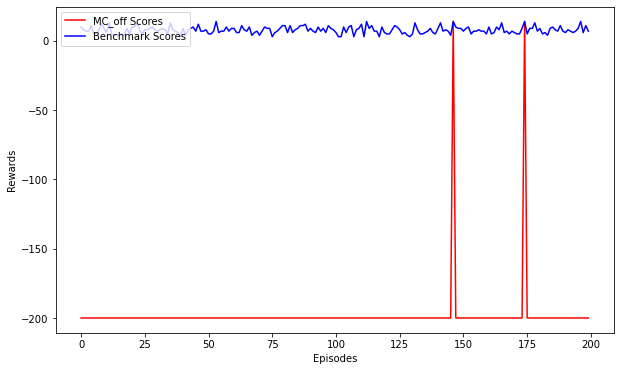

In [187]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)


plt.plot(scores,c='r', ls='-',label='MC_off Scores')
plt.plot(benchmark_scores,c='b', ls='-',label='Benchmark Scores')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)
plt.show()

# DynaQ

In [188]:
np.random.seed(1234)
Q=load('model_output/final_DynaQ_50K.pkl')
env.reset()
scores =[]
benchmark_scores =[]
# env.render()
r=0
 
for e in range(test_episodes):
    i=0
#     print('***********************{}********************'.format(e))
    done = False
    state = env.reset()
    score=benchmark(state,False)
    benchmark_scores.append(score)
    r=0
    while not done:
#         env.render()
        action = np.argmax(Q[state])
        #print(action)
        new_state, reward, done, info = env.step(action)
        r+=reward
        state = new_state
        i=i+1
#         print('i: {}, r:{}'.format(i, r))
        if done:
            scores.append(r)
#             print(r)
            break
env.close()    
DynaQ_rewards=scores
print('the score is: {}, benchmark score  is:{}'.format(sum(scores)/test_episodes, sum(benchmark_scores)/test_episodes))

the score is: 8.115, benchmark score  is:8.115


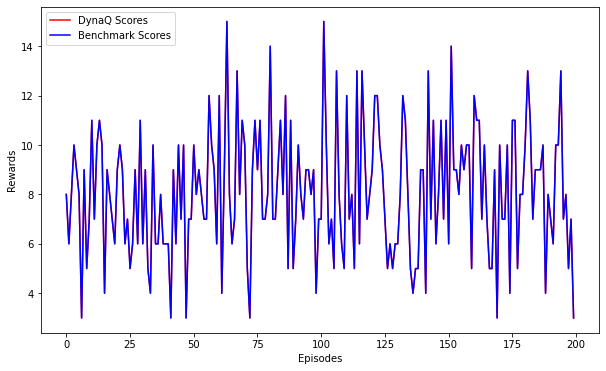

In [189]:

import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)


plt.plot(scores,c='r', ls='-',label='DynaQ Scores')
plt.plot(benchmark_scores,c='b', ls='-',label='Benchmark Scores')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)
plt.show()

# QLearning

In [190]:
np.random.seed(1234)
Q=load('model_output/final_QLearning_50K.pkl')
scores =[]
benchmark_scores =[]
r=0
for e in range(test_episodes):
    #print('***********************{}********************'.format(e))
    done = False
    state = env.reset()
    score=benchmark(state,False)
    state1 = state
    benchmark_scores.append(score)
    r=0
    while not done:
        action = np.argmax(Q[state])
        #print(action)
        new_state, reward, done, info = env.step(action)
        r+=reward
        state = new_state
        if done:
            scores.append(r)
            if  r>score :
                print(state1)
            break
env.close()    
QLearning_rewards=scores
print('the score is: {}, benchmark score  is:{}'.format(sum(scores)/test_episodes, sum(benchmark_scores)/test_episodes))

the score is: 8.06, benchmark score  is:8.06


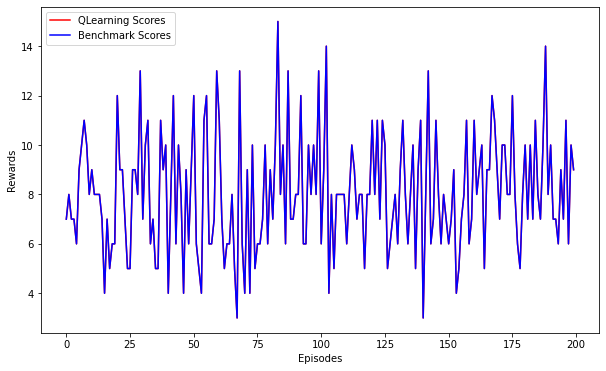

In [191]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)


plt.plot(scores,c='r', ls='-',label='QLearning Scores')
plt.plot(benchmark_scores,c='b', ls='-',label='Benchmark Scores')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)
plt.show()

# sarsa

In [192]:
 
Q=load('model_output/final_sarsa_50K.pkl')
scores =[]
benchmark_scores =[]
r=0
for e in range(test_episodes):
    #print('***********************{}********************'.format(e))
    done = False
    state = env.reset()
    score=benchmark(state,False)
    benchmark_scores.append(score)
    r=0
    while not done:
 
        action = np.argmax(Q[state])
        #print(action)
        new_state, reward, done, info = env.step(action)
        r+=reward
        state = new_state
        if done:
            scores.append(r)
            break
env.close()    
QLearning_rewards=scores
print('the score is: {}, benchmark score  is:{}'.format(sum(scores)/test_episodes, sum(benchmark_scores)/test_episodes))

the score is: -81.385, benchmark score  is:7.6


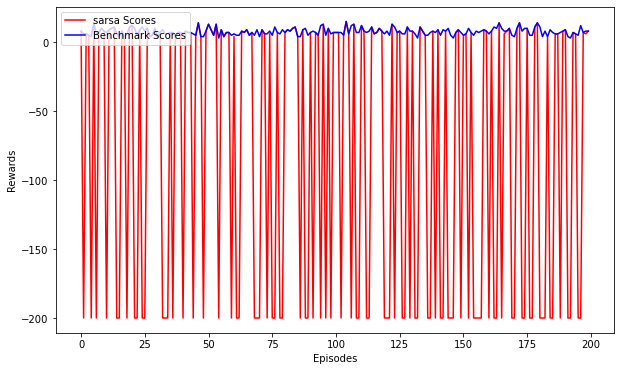

In [193]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)


plt.plot(scores,c='r', ls='-',label='sarsa Scores')
plt.plot(benchmark_scores,c='b', ls='-',label='Benchmark Scores')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)
plt.show()

# DQN

In [194]:
decode_states=[]
for i in range(500):
    decode_states.append(list(env.decode (i) ))  

In [195]:
from agents import dqn
output_dir = 'model_output/'

In [196]:
agent =  dqn.DQNAgent(4,6, env, decode_states,1,10, output_dir ,False) # initialise agent

In [197]:
agent.load(agent.output_dir + "final_weights.hdf5")

In [198]:
test_episodes=200
env.reset()
scores =[]
benchmark_scores =[]
r=0
for e in range(test_episodes):
#     print('***********************{}********************'.format(e))
    done = False
    state = env.reset()
    score=benchmark(state,False)
    benchmark_scores.append(score)
    r=0
    while not done:
#         env.render()
        s =[]
        s.append(  decode_states[state]) 
        act_values = agent.q_estimator.predict(np.array(s))
        action=np.argmax(act_values[0])
#         print(action)
        new_state, reward, done, info = env.step(action)
        r+=reward
        state = new_state
#         print(reward)
        if done:
            scores.append(r)
#             print(r)
            break
env.close()    
DQN_rewards=scores
print('the score is: {}, benchmark score  is:{}'.format(sum(scores)/test_episodes, sum(benchmark_scores)/test_episodes))

the score is: 8.115, benchmark score  is:8.115


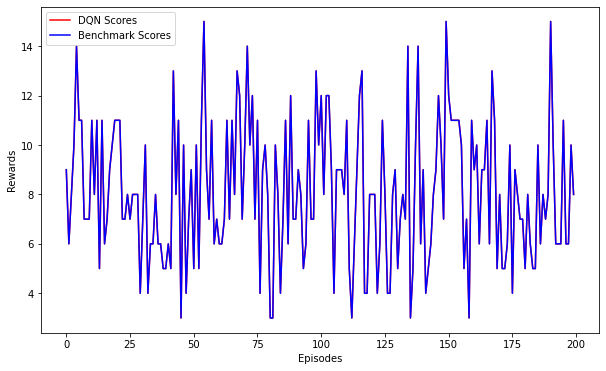

In [199]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)


plt.plot(scores,c='r', ls='-',label='DQN Scores')
plt.plot(benchmark_scores,c='b', ls='-',label='Benchmark Scores')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)
plt.show()